# PBO learnt on one iteration and two weigths

## Define paramters

In [1]:
%load_ext autoreload
%autoreload 2

import jax

# keys
seed = 1
key = jax.random.PRNGKey(seed)
env_key, key = jax.random.split(key)
shuffle_key, q_network_key, random_weights_key, pbo_network_key = jax.random.split(key, 4)

# Box over states and actions
max_discrete_state = 7
n_discrete_states = 5
max_discrete_action = 9
n_discrete_actions = 7

gamma = 1
n_weights = 3

# Q function
layer_dimension = 50
action_range_on_max = max_discrete_action
n_actions_on_max = 50

# PBO trainings
max_iterations = 10000
batch_size_samples = 12
batch_size_weights = 2
learning_rate = 0.0001
tolerance = 1

# Visualisation
plot_freq = 200
sleeping_time = 0

## Define environment

In [2]:
import numpy as np

from pbo.environment.linear_quadratic import LinearQuadraticEnv


discrete_states = np.linspace(-max_discrete_state, max_discrete_state, n_discrete_states)
state_box_half_size = max_discrete_state / n_discrete_states
discrete_states_boxes = np.linspace(
    -max_discrete_state - state_box_half_size, max_discrete_state + state_box_half_size, n_discrete_states + 1
)

discrete_actions = np.linspace(-max_discrete_action, max_discrete_action, n_discrete_actions)
action_box_half_size = max_discrete_action / n_discrete_actions
discrete_actions_boxes = np.linspace(
    -max_discrete_action - action_box_half_size, max_discrete_action + action_box_half_size, n_discrete_actions + 1
)

env = LinearQuadraticEnv(env_key, max_init_state=max_discrete_state)

Transition: s' = As + Ba
Transition: s' = -0.5264108180999756s + 0.7340433597564697a
Reward: Qs² + Ra² + 2 Ssa
Reward: -0.9019700288772583s² + 0.12905049324035645a² + 0.4164412021636963sa


## Collect samples

### Samples on the crosses of the box

In [3]:
import jax.numpy as jnp

from pbo.sample_collection.replay_buffer import ReplayBuffer


n_samples = n_discrete_states * n_discrete_actions
replay_buffer = ReplayBuffer()

state = env.reset()
idx_sample = 0
epidose_length = 0

for state in discrete_states:
    for action in discrete_actions:
        env.reset(jnp.array([state]))
        next_state, reward, _, _ = env.step(jnp.array([action]))

        replay_buffer.add(jnp.array([state]), jnp.array([action]), reward, next_state)

## Visualize samples

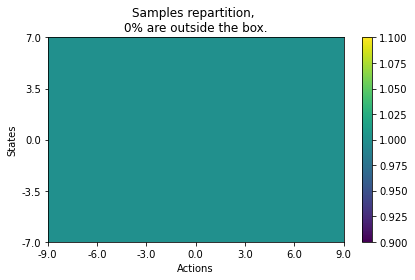

In [4]:
from pbo.sample_collection.count_samples import count_samples
from pbo.utils.state_action_mesh import StateActionMesh


samples_count, n_outside_boxes = count_samples(replay_buffer, discrete_states_boxes, discrete_actions_boxes)
samples_visu_mesh = StateActionMesh(discrete_states, discrete_actions, sleeping_time=0)

samples_visu_mesh.set_values(samples_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box."
)


## Build q network

In [5]:
from pbo.networks.jax.q import FullyConnectedQ


q = FullyConnectedQ(
    layer_dimension=layer_dimension,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    action_range_on_max=action_range_on_max,
    n_actions_on_max=n_actions_on_max,
)

## Build PBO network and its dataloaders

In [6]:
from pbo.networks.jax.pbo import LinearPBO
from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.weights_collection.dataloader import WeightsDataLoader


pbo = LinearPBO(pbo_network_key, gamma, q, learning_rate)

replay_buffer.cast_to_jax_array()
data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)

random_weights_qs = jnp.vstack([q.random_init_weights() for _ in range(n_weights)])
data_loader_weights = WeightsDataLoader(random_weights_qs, batch_size_weights, shuffle_key)

## Train PBO on one iteration over one random init weight

### Define the targets of the random init weights

In [7]:
full_batch = {
    "reward": replay_buffer.rewards,
    "next_state": replay_buffer.next_states,
}
target_discrete_iterated_qs = pbo.compute_target(full_batch, data_loader_weights.weights).reshape((n_weights, n_discrete_states, n_discrete_actions))

### Training

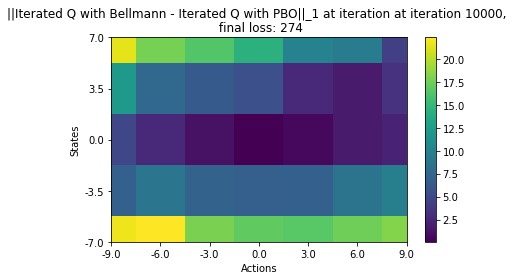

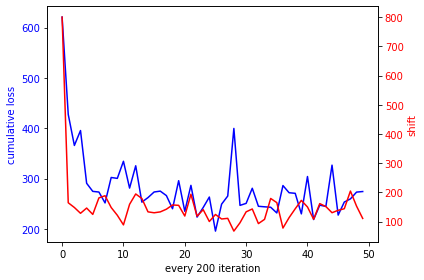

In [8]:
from pbo.utils.shared_axis_plot import shared_axis_plot


# For visualization
q_visu_mesh = StateActionMesh(discrete_states, discrete_actions, sleeping_time)
former_discrete_iterated_qs = q.discretize(pbo.network.apply(pbo.params, data_loader_weights.weights), discrete_states, discrete_actions)
cumulative_losses = []
shifts = []

iteration = 0
cumulative_loss = float("inf")
stopping_criterion = tolerance * data_loader_weights.n_weights * data_loader_samples.n_samples

while cumulative_loss > stopping_criterion and iteration < max_iterations:
    cumulative_loss = 0
    
    data_loader_weights.shuffle()
    for batch_weights in data_loader_weights:
        data_loader_samples.shuffle()
        for batch_samples in data_loader_samples:
            cumulative_loss += pbo.learn_on_batch(batch_samples, batch_weights)

    iteration += 1

    # Visualization
    if iteration % plot_freq == 0:
        discrete_iterated_qs = q.discretize(pbo.network.apply(pbo.params, data_loader_weights.weights), discrete_states, discrete_actions)
        shift = jnp.abs(discrete_iterated_qs - former_discrete_iterated_qs).sum(axis=(1, 2)).mean()

        q_visu_mesh.set_values(np.abs(target_discrete_iterated_qs - discrete_iterated_qs).sum(axis=0))
        q_visu_mesh.show(f"||Iterated Q with Bellmann - Iterated Q with PBO||_1 at iteration {iteration}, \nloss: {int(cumulative_loss)}, shift: {int(shift)}, stopping criterion: {stopping_criterion}")
        
        cumulative_losses.append(cumulative_loss)
        shifts.append(shift)
        former_discrete_iterated_qs = discrete_iterated_qs

final_discrete_iterated_qs = q.discretize(pbo.network.apply(pbo.params, data_loader_weights.weights), discrete_states, discrete_actions)

q_visu_mesh.set_values(np.abs(target_discrete_iterated_qs - final_discrete_iterated_qs).sum(axis=0))
q_visu_mesh.show(f"||Iterated Q with Bellmann - Iterated Q with PBO||_1 at iteration at iteration {iteration}, \n final loss: {int(cumulative_loss)}")

shared_axis_plot(cumulative_losses, shifts, f"every {plot_freq} iteration", "cumulative loss", "shift")